In [1]:
import os
import pickle
import random
import time

import PIL
import numpy as np
import pandas as pd
import tensorflow as tf
from PIL import Image
from keras import Input, Model
from keras import backend as K
from keras.callbacks import TensorBoard
from keras.layers import Dense, LeakyReLU, BatchNormalization, ReLU, Reshape, UpSampling2D, Conv2D, Activation, \
    concatenate, Flatten, Lambda, Concatenate, ZeroPadding2D
from keras.layers import add
from keras.optimizers import Adam
from keras.utils import to_categorical
from matplotlib import pyplot as plt

Using TensorFlow backend.


In [0]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

import h5py 
hf = h5py.File('drive/My Drive/csci566/deepfashion.hdf5','r+')   
imgs = np.array(hf['images'].value)
one_hot_labels = np.array(hf['labels'].value)
labels = np.argmax(one_hot_labels, axis=1)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
imgs = imgs[:3000, :, :, :]
labels = labels[:3000]

print(imgs.shape)
print(labels.shape)

(3000, 128, 128, 3)
(3000,)


In [5]:
X_train, y_train = imgs, labels
NUM_CLASSES = len(np.unique(labels))

print("Number of classes:", NUM_CLASSES)

Number of classes: 7


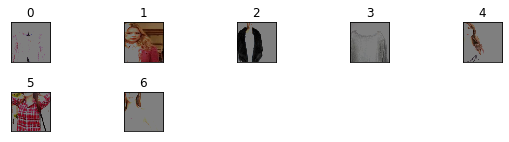

In [6]:
num_classes = len(np.unique(y_train))
class_names = [i for i in range(0, num_classes)]

fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = plt.subplot(3, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(y_train[:]==i)[0]
    features_idx = X_train[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    img = features_idx[img_num,::]
    ax.set_title(class_names[i])
    plt.imshow(img)
    
plt.tight_layout()

In [7]:
from skimage.transform import rescale
X_train_rescaled = np.zeros(shape = (X_train.shape[0], 64, 64, 3))
for i in range(X_train.shape[0]):
  X_train_rescaled[i] = rescale(X_train[i], 0.5, anti_aliasing=False)

print("Low res shape")
print(X_train_rescaled.shape)

X_train_normalized = np.zeros(shape = (X_train.shape[0], 128, 128, 3))
for i in range(X_train.shape[0]):
  X_train_normalized[i] = rescale(X_train[i], 1, anti_aliasing=False)

print("High res shpae")
print(X_train_normalized.shape)

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:23: UserWarning: The default multichannel argument (None) is deprecated.  Please specify either True or False explicitly.  multichannel will default to False starting with release 0.16.
  warn('The default multichannel argument (None) is deprecated.  Please '


Low res shape
(3000, 64, 64, 3)
High res shpae
(3000, 128, 128, 3)


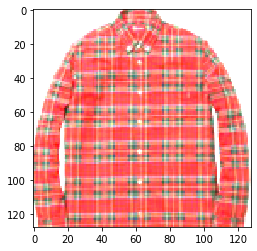

In [8]:
X_lr_train = X_train_rescaled
X_hr_train = X_train_normalized

plt.imshow(X_hr_train[0], interpolation='nearest')
plt.show()

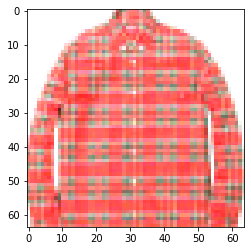

In [9]:
plt.imshow(X_lr_train[0], interpolation='nearest')
plt.show()

In [0]:
def build_stage1_generator():
    """
    Builds a generator model used in Stage-I
    """
    # input_layer = Input(shape=(1024,))
    # x = Dense(256)(input_layer)
    # mean_logsigma = LeakyReLU(alpha=0.2)(x)

    # c = Lambda(generate_c)(mean_logsigma)

    input_layer = Input(shape=(100,))
    labels = Input(shape=(NUM_CLASSES,))

    gen_input = Concatenate(axis=1)([input_layer, labels])

    x = Dense(128 * 8 * 4 * 4, use_bias=False)(gen_input)
    x = ReLU()(x)

    x = Reshape((4, 4, 128 * 8), input_shape=(128 * 8 * 4 * 4,))(x)

    x = UpSampling2D(size=(2, 2))(x)
    x = Conv2D(512, kernel_size=3, padding="same", strides=1, use_bias=False)(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = UpSampling2D(size=(2, 2))(x)
    x = Conv2D(256, kernel_size=3, padding="same", strides=1, use_bias=False)(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = UpSampling2D(size=(2, 2))(x)
    x = Conv2D(128, kernel_size=3, padding="same", strides=1, use_bias=False)(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = UpSampling2D(size=(2, 2))(x)
    x = Conv2D(64, kernel_size=3, padding="same", strides=1, use_bias=False)(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = Conv2D(3, kernel_size=3, padding="same", strides=1, use_bias=False)(x)
    x = Activation(activation='tanh')(x)

    stage1_gen = Model(inputs=[input_layer, labels], outputs=[x])
    return stage1_gen

In [0]:
def residual_block(input):
    """
    Residual block in the generator network
    """
    x = Conv2D(128 * 4, kernel_size=(3, 3), padding='same', strides=1)(input)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = Conv2D(128 * 4, kernel_size=(3, 3), strides=1, padding='same')(x)
    x = BatchNormalization()(x)

    x = add([x, input])
    x = ReLU()(x)

    return x

In [0]:
def build_stage2_generator():
    """
    Create Stage-II generator containing the CA Augmentation Network,
    the image encoder and the generator network
    """

    # 1. CA Augmentation Network
    # input_layer = Input(shape=(1024,))
    input_lr_images = Input(shape=(64, 64, 3))

    # ca = Dense(256)(input_layer)
    # mean_logsigma = LeakyReLU(alpha=0.2)(ca)
    # c = Lambda(generate_c)(mean_logsigma)

    # 2. Image Encoder
    x = ZeroPadding2D(padding=(1, 1))(input_lr_images)
    x = Conv2D(128, kernel_size=(3, 3), strides=1, use_bias=False)(x)
    x = ReLU()(x)

    x = ZeroPadding2D(padding=(1, 1))(x)
    x = Conv2D(256, kernel_size=(4, 4), strides=2, use_bias=False)(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = ZeroPadding2D(padding=(1, 1))(x)
    x = Conv2D(512, kernel_size=(4, 4), strides=2, use_bias=False)(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    # 3. Joint
    # c_code = Lambda(joint_block)([c, x])

    # x = ZeroPadding2D(padding=(1, 1))(c_code)
    x = ZeroPadding2D(padding=(1, 1))(x)
    x = Conv2D(512, kernel_size=(3, 3), strides=1, use_bias=False)(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    # 4. Residual blocks
    x = residual_block(x)
    x = residual_block(x)
    x = residual_block(x)
    x = residual_block(x)

    # 5. Upsampling blocks
    x = UpSampling2D(size=(2, 2))(x)
    x = Conv2D(512, kernel_size=3, padding="same", strides=1, use_bias=False)(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = UpSampling2D(size=(2, 2))(x)
    x = Conv2D(256, kernel_size=3, padding="same", strides=1, use_bias=False)(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = UpSampling2D(size=(2, 2))(x)
    x = Conv2D(128, kernel_size=3, padding="same", strides=1, use_bias=False)(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    # x = UpSampling2D(size=(2, 2))(x)
    # x = Conv2D(64, kernel_size=3, padding="same", strides=1, use_bias=False)(x)
    # x = BatchNormalization()(x)
    # x = ReLU()(x)

    x = Conv2D(3, kernel_size=3, padding="same", strides=1, use_bias=False)(x)
    x = Activation('tanh')(x)

    #model = Model(inputs=[input_lr_images, labels], outputs=[x])
    model = Model(inputs=[input_lr_images], outputs=[x])
    return model

In [0]:
def build_stage2_discriminator():
    """
    Create Stage-II discriminator network
    """
    input_layer = Input(shape=(128, 128, 3))

    x = Conv2D(64, (4, 4), padding='same', strides=2, input_shape=(128, 128, 3), use_bias=False)(input_layer)
    x = LeakyReLU(alpha=0.2)(x)

    x = Conv2D(128, (4, 4), padding='same', strides=2, use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)

    x = Conv2D(256, (4, 4), padding='same', strides=2, use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)

    x = Conv2D(512, (4, 4), padding='same', strides=2, use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)

    x = Conv2D(1024, (4, 4), padding='same', strides=2, use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)

    x = Conv2D(2048, (4, 4), padding='same', strides=2, use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)

    x = Conv2D(1024, (1, 1), padding='same', strides=1, use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)

    x = Conv2D(512, (1, 1), padding='same', strides=1, use_bias=False)(x)
    x = BatchNormalization()(x)

    x2 = Conv2D(128, (1, 1), padding='same', strides=1, use_bias=False)(x)
    x2 = BatchNormalization()(x2)
    x2 = LeakyReLU(alpha=0.2)(x2)

    x2 = Conv2D(128, (3, 3), padding='same', strides=1, use_bias=False)(x2)
    x2 = BatchNormalization()(x2)
    x2 = LeakyReLU(alpha=0.2)(x2)

    x2 = Conv2D(512, (3, 3), padding='same', strides=1, use_bias=False)(x2)
    x2 = BatchNormalization()(x2)

    added_x = add([x, x2])
    added_x = LeakyReLU(alpha=0.2)(added_x)

    # input_layer2 = Input(shape=(4, 4, 128))

    # merged_input = concatenate([added_x, input_layer2])

    x3 = Conv2D(64 * 8, kernel_size=1, padding="same", strides=1)(added_x)
    x3 = BatchNormalization()(x3)
    x3 = LeakyReLU(alpha=0.2)(x3)
    x3 = Flatten()(x3)

    labels = Input(shape=(NUM_CLASSES,))
    merged_input = concatenate([x3, labels])

    x3 = Dense(1)(merged_input)
    x3 = Activation('sigmoid')(x3)

    stage2_dis = Model(inputs=[input_layer, labels], outputs=[x3])
    return stage2_dis

In [0]:
def build_adversarial_model(gen_model2, dis_model, gen_model1):
    """
    Create adversarial model
    """
    # embeddings_input_layer = Input(shape=(1024, ))
    noise_input_layer = Input(shape=(100, ))
    labels = Input(shape=(NUM_CLASSES,))
    # compressed_embedding_input_layer = Input(shape=(4, 4, 128))

    gen_model1.trainable = False
    dis_model.trainable = False

    lr_images = gen_model1([noise_input_layer, labels])
    hr_images = gen_model2([lr_images])
    valid = dis_model([hr_images, labels])

    model = Model(inputs=[noise_input_layer, labels], outputs=[valid])
    return model


In [0]:
"""
Loss functions
"""


def KL_loss(y_true, y_pred):
    mean = y_pred[:, :128]
    logsigma = y_pred[:, :128]
    loss = -logsigma + .5 * (-1 + K.exp(2. * logsigma) + K.square(mean))
    loss = K.mean(loss)
    return loss


def custom_generator_loss(y_true, y_pred):
    # Calculate binary cross entropy loss
    return K.binary_crossentropy(y_true, y_pred)


def write_log(callback, name, loss, batch_no):
    """
    Write training summary to TensorBoard
    """
    summary = tf.Summary()
    summary_value = summary.value.add()
    summary_value.simple_value = loss
    summary_value.tag = name
    callback.writer.add_summary(summary, batch_no)
    callback.writer.flush()


def save_rgb_img(img, path):
    """
    Save an rgb image
    """
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    ax.imshow(img)
    ax.axis("off")
    ax.set_title("Image")

    plt.savefig(path)
    plt.close()


In [0]:
if __name__ == '__main__':
    hr_image_size = (128, 128)
    lr_image_size = (64, 64)
    batch_size = 4
    z_dim = 100
    stage1_generator_lr = 0.0002
    stage1_discriminator_lr = 0.0002
    stage1_lr_decay_step = 600
    epochs = 2
    condition_dim = 128

    # Define optimizers
    dis_optimizer = Adam(lr=stage1_discriminator_lr, beta_1=0.5, beta_2=0.999)
    gen_optimizer = Adam(lr=stage1_generator_lr, beta_1=0.5, beta_2=0.999)


    """
    Build and compile models
    """

    print("building stage2 dis")
    stage2_dis = build_stage2_discriminator()
    stage2_dis.compile(loss='binary_crossentropy', optimizer=dis_optimizer)

    print("building stage1 gen")
    stage1_gen = build_stage1_generator()
    stage1_gen.compile(loss="binary_crossentropy", optimizer=gen_optimizer)

    stage1_gen.load_weights("stage1_gen.h5")

    print("building stage2 gen")
    stage2_gen = build_stage2_generator()
    stage2_gen.compile(loss="binary_crossentropy", optimizer=gen_optimizer)

    print("finished building optimizers")

    adversarial_model = build_adversarial_model(stage2_gen, stage2_dis, stage1_gen)

    print("built adversarial model")
    # adversarial_model.compile(loss=['binary_crossentropy', KL_loss], loss_weights=[1.0, 2.0],
    #                           optimizer=gen_optimizer, metrics=None)
    adversarial_model.compile(loss=['binary_crossentropy'], loss_weights=[1.0],
                              optimizer=gen_optimizer, metrics=None)

    # tensorboard = TensorBoard(log_dir="logs/".format(time.time()))
    # tensorboard.set_model(stage2_gen)
    # tensorboard.set_model(stage2_dis)

    # Generate an array containing real and fake values
    # Apply label smoothing
    real_labels = np.ones((batch_size, 1), dtype=float) * 0.9
    fake_labels = np.zeros((batch_size, 1), dtype=float) * 0.1

    for epoch in range(epochs):
        print("========================================")
        print("Epoch is:", epoch)

        gen_losses = []
        dis_losses = []

        # Load data and train model
        number_of_batches = int(X_hr_train.shape[0] / batch_size)
        print("Number of batches:{}".format(number_of_batches))
        for index in range(number_of_batches):
            print("Batch:{}".format(index+1))

            # Create a noise vector
            z_noise = np.random.normal(0, 1, size=(batch_size, z_dim))
            X_hr_train_batch = X_hr_train[index * batch_size:(index + 1) * batch_size]
            # embedding_batch = embeddings_train[index * batch_size:(index + 1) * batch_size]
            # X_hr_train_batch = (X_hr_train_batch - 127.5) / 127.5

            label_batch = to_categorical(y_train[index * batch_size:(index + 1) * batch_size].reshape(-1, 1), num_classes=NUM_CLASSES)

            # Generate fake images
            lr_fake_images = stage1_gen.predict([z_noise, label_batch], verbose=3)
            hr_fake_images = stage2_gen.predict([lr_fake_images], verbose=3)

            # """
            # 4. Generate compressed embeddings
            # """
            # compressed_embedding = embedding_compressor_model.predict_on_batch(embedding_batch)
            # compressed_embedding = np.reshape(compressed_embedding, (-1, 1, 1, condition_dim))
            # compressed_embedding = np.tile(compressed_embedding, (1, 4, 4, 1))

            """
            5. Train the discriminator model
            """

            dis_loss_real = stage2_dis.train_on_batch([X_hr_train_batch, label_batch],
                                                      np.reshape(real_labels, (batch_size, 1)))
            dis_loss_fake = stage2_dis.train_on_batch([hr_fake_images, label_batch],
                                                      np.reshape(fake_labels, (batch_size, 1)))
            dis_loss_wrong = stage2_dis.train_on_batch([X_hr_train_batch[:(batch_size - 1)], label_batch[1:]],
                                                       np.reshape(fake_labels[1:], (batch_size-1, 1)))
            d_loss = 0.5 * np.add(dis_loss_real, 0.5 * np.add(dis_loss_wrong,  dis_loss_fake))
            print("d_loss:{}".format(d_loss))

            """
            Train the adversarial model
            """
            g_loss = adversarial_model.train_on_batch([z_noise, label_batch],
                                                                [K.ones((batch_size, 1)) * 0.9])

            print("g_loss:{}".format(g_loss))

            dis_losses.append(d_loss)
            gen_losses.append(g_loss)

        """
        Save losses to Tensorboard after each epoch
        """
        # write_log(tensorboard, 'discriminator_loss', np.mean(dis_losses), epoch)
        # write_log(tensorboard, 'generator_loss', np.mean(gen_losses)[0], epoch)

        # Generate and save images after every 2nd epoch
        if epoch % 2 == 0:
            # z_noise2 = np.random.uniform(-1, 1, size=(batch_size, z_dim))
            z_noise2 = np.random.normal(0, 1, size=(NUM_CLASSES, z_dim))
            labels2 = to_categorical(np.arange(0, NUM_CLASSES).reshape(-1, 1), NUM_CLASSES)

            lr_fake_images = stage1_gen.predict([z_noise2, labels2], verbose=3)
            hr_fake_images = stage2_gen.predict([lr_fake_images], verbose=3)

            # Save images
            for i, img in enumerate(hr_fake_images[:10]):
                save_rgb_img(img, "results2/gen_{}_{}.png".format(epoch, i))

    # Saving the models
    stage2_gen.save_weights("stage2_gen.h5")
    stage2_dis.save_weights("stage2_dis.h5")

building stage2 dis













Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
building stage1 gen

building stage2 gen
finished building optimizers
built adversarial model
Epoch is: 0
Number of batches:750
Batch:1


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


d_loss:2.3055211305618286
g_loss:1.4737709760665894
Batch:2
d_loss:2.4523688554763794


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


g_loss:4.915804386138916
Batch:3
d_loss:2.0768561959266663
g_loss:3.331737518310547
Batch:4
d_loss:1.5790534615516663
g_loss:2.226773738861084
Batch:5
d_loss:1.5153851509094238
g_loss:2.0887022018432617
Batch:6
d_loss:1.5032235085964203
g_loss:2.448120594024658
Batch:7
d_loss:1.45854651927948
g_loss:2.3161792755126953
Batch:8
d_loss:1.2167113721370697
g_loss:2.894845724105835
Batch:9
d_loss:1.5035946071147919
g_loss:2.1844558715820312
Batch:10
d_loss:1.1149249970912933
g_loss:2.4887096881866455
Batch:11
d_loss:0.9454469978809357
g_loss:1.4239346981048584
Batch:12
d_loss:1.0769215822219849
g_loss:2.1192853450775146
Batch:13
d_loss:0.9536307752132416
g_loss:1.731163740158081
Batch:14
d_loss:0.870027095079422
g_loss:2.208066940307617
Batch:15
d_loss:1.147309809923172
g_loss:1.9136549234390259
Batch:16
d_loss:0.9074137359857559
g_loss:1.4491206407546997
Batch:17
d_loss:1.0513542890548706
g_loss:1.4273602962493896
Batch:18
d_loss:0.7979129999876022
g_loss:1.3074979782104492
Batch:19
d_loss:

In [0]:
# Create & upload a file.
uploaded = drive.CreateFile({'title': 'stage2_dis.h5'})
uploaded.SetContentFile('stage2_dis.h5')
uploaded.Upload()
print('Uploaded file with ID {}'.format(uploaded.get('id')))

In [0]:
# Create & upload a file.
uploaded = drive.CreateFile({'title': 'stage2_gen.h5'})
uploaded.SetContentFile('stage2_gen.h5')
uploaded.Upload()
print('Uploaded file with ID {}'.format(uploaded.get('id')))

In [0]:
# Create & upload a file.
uploaded = drive.CreateFile({'title': 'stage1_gen.h5'})
uploaded.SetContentFile('stage1_gen.h5')
uploaded.Upload()
print('Uploaded file with ID {}'.format(uploaded.get('id')))